### SUNA Nitrate Filter

- 35hr lanzcos cosine squared filter
- timeseries must be hourly
- timeseries must be gridded (no gaps) or it will be linearly interpolated to fill gaps
- currently, prior gaps get replicated in results.  Gaps of 6hrs or less should not need to have any special treatment of data on wings of gap.  Gaps of greater than 6hrs should have 17 hours on either side of the gap removed to account for the filter window.  This is implemented in algorithm.
- TODO:  Address missing data at start/end of timeseries more completely
- TODO:  apply spectral filling routine to eliminate gaps up to 36 hours




## File input format

csv file for input, must have time labeled as 'date' and desired variable to be filtered must be edited below

time can be either a string or excel serial date

## Software Requirements

Developed/tested for:
- python >=3.6 ** Tested
- python =2.7 ** Works as of 7/15/19 but not developed for (more extensive 'vtools' needs python 2.7)

requires:
- jupyterlab (jupyter notebooks) for running this notebook
- pandas >= 0.24.2
- numpy >= 1.15.4
- lanzcos (local library)
- matplotlib for plotting (optional)

In [175]:
import datetime

import pandas as pd
import numpy as np
import lanzcos

from netCDF4 import num2date


In [176]:
#raw data - path below should be full path to file
path_to_file = '/Users/bell/in_and_outbox/2019/mordy/wisegarver/origdata/17ckp1a_merge_190715_f35.csv'
time_column_name = 'date' #change only if variable has different name
var2filter_name = 'no3' #change based on variable to filter

In [177]:
data=pd.read_csv(path_to_file,
                 na_values = [1.0e35],
                 parse_dates=True,
                 index_col=time_column_name)

#linearly interpolate gaps less then a threshold value
# arctic data without tides, this value can be 6hr but bering data should be less... 2-3hr

try:
    data = data.resample('1H').mean() #mandate hourly data
except:
    print('Time passed as excel date - converting first')
    #excel starts counting at one and this is a delta measurement so '-2' from excel date captures both issues
    data['datetime'] = num2date(data.index-2,'days since 1900-1-1')
    #excel integer representation is not exact so rounding to nearest hour needs to happen before resampling
    data.set_index('datetime',inplace=True)
    data.index = data.index.round("H")
    data = data.resample('1H').mean() #mandate hourly data
    
## missing data fill limited by number of hours to linearly interpolate
temp = data[var2filter_name].interpolate(method='time',limit=6)

# get index of missing data that wasn't filled
# the remaining missing data will continue to be missing after analysis
# this data and the edges of the timeseries need to have the effects of the filter window accounted for

missing_index = np.isnan(temp)
temp = data[var2filter_name].interpolate(method='time')

#address gaps at beginning and end... back fill... and forward fill at end... 
# the filter window will correct small gaps at the tails but will become worse as the leading gaps get bigger
temp.bfill(inplace=True)
temp.ffill(inplace=True)

In [178]:
#filter data with lanzcos filter
data[var2filter_name+'_f35'] = lanzcos.lanzcos(temp.values,1,35)

In [179]:
#not sure why but results of filtered data seem to need the mean of the sample
# to be added back
print("{} is close to zero for mean of filtered data".format(data[var2filter_name+'_f35'].mean()))
print("{} is for mean of unfiltered data".format(data[var2filter_name].mean()))
print("{} is the mean of difference of filtered and unfiltered data".format(
    (data[var2filter_name+'_f35']-data[var2filter_name]).mean()))



-2.6886048643120848e-15 is close to zero for mean of filtered data
10.28913969715381 is for mean of unfiltered data
-10.289466541469746 is the mean of difference of filtered and unfiltered data


In [180]:
#filter data with rudimentary matlab script - mean offset corrected
data[var2filter_name+'_f35'] = lanzcos.lanzcos(temp.values,1,35)+data[var2filter_name].mean()
data[var2filter_name+'_f35'][missing_index] = np.nan

In [181]:
#remove boundaries of large gaps

for index, row in data[np.isnan(data[var2filter_name+'_f35'])].iterrows():
    data[var2filter_name+'_f35'][index-datetime.timedelta(hours=17):index+datetime.timedelta(hours=17)] = np.nan
    
#remove start/end boundaries
for index in range(0,17):
    data.loc[data.index[index]][var2filter_name+'_f35'] =np.nan

for index in range(len(data)-17,len(data)):
    data.loc[data.index[index]][var2filter_name+'_f35'] =np.nan

## Plot data for Visual Representation

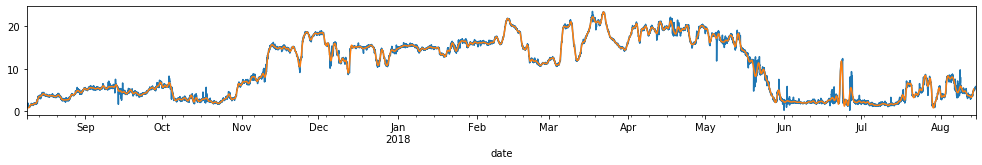

In [182]:
%matplotlib inline

# only for plotting timeseries
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.dates import YearLocator, WeekdayLocator, MonthLocator, DayLocator, HourLocator, DateFormatter
import matplotlib.ticker as ticker
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(17, 2))

data[var2filter_name].plot()
data[var2filter_name+'_f35'].plot()


## Output results file in csv for archive

In [183]:
data.to_csv(path_to_file.replace('.csv','_f35.csv'))